In [28]:
MAIN_FOLDER = ".."

In [29]:
import pandas as pd
import numpy as np
import joblib
import os
import sys

sys.path.append(MAIN_FOLDER)
import utils.resp_enc as resp


# import all models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
import xgboost as xgb
import lightgbm as lgb

# import all metrics
import sklearn.metrics as metrics

import warnings

warnings.filterwarnings("ignore")
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [30]:
# read data
train = pd.read_csv(os.path.join(MAIN_FOLDER, "data/train.csv"))
test = pd.read_csv(os.path.join(MAIN_FOLDER, "data/test.csv"))

train.shape, test.shape

((5634, 18), (1409, 18))

In [31]:
train.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,8173-RXAYP,0,Yes,Yes,24,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,0
1,1325-USMEC,0,Yes,No,70,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Two year,Yes,Credit card (automatic),99.35,0
2,6892-BOGQE,0,Yes,No,71,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.90,0
3,7134-MJPDY,1,No,No,66,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),102.85,0
4,2535-PBCGC,0,Yes,No,70,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),64.55,0


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5634 non-null   object 
 4   tenure            5634 non-null   int64  
 5   MultipleLines     5634 non-null   object 
 6   InternetService   5634 non-null   object 
 7   OnlineSecurity    5634 non-null   object 
 8   OnlineBackup      5634 non-null   object 
 9   DeviceProtection  5634 non-null   object 
 10  TechSupport       5634 non-null   object 
 11  StreamingTV       5634 non-null   object 
 12  StreamingMovies   5634 non-null   object 
 13  Contract          5634 non-null   object 
 14  PaperlessBilling  5634 non-null   object 
 15  PaymentMethod     5634 non-null   object 
 16  MonthlyCharges    5634 non-null   float64


Get those columns which are of object type and those columns which are of int type

In [ ]:
train.drop("customerID", axis=1, inplace=True)
test.drop("customerID", axis=1, inplace=True)

In [7]:
get_obj_cols = [col for col in train.columns if train[col].dtype == "object"]
get_int_cols = [col for col in train.columns if train[col].dtype != "object"]

# Response Encoding

[More info check this link](https://medium.com/@thewingedwolf.winterfell/response-coding-for-categorical-data-7bb8916c6dc1)

We will response encode the categorical data instead of using one hot encoding the categorical data. The below is the code for that.

In [8]:
# fit the response_encoding class to the train data
# response encoding all the categorical columns
# resp_enc = resp.response_encoding(cols=get_obj_cols,target='Churn',alpha=0.1, target_value=1)
# resp_enc.fit(train)
resp_enc = joblib.load(os.path.join(MAIN_FOLDER, "model/resp_enc.pkl"))
train = resp_enc.transform(train)
test = resp_enc.transform(test)

train.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,0.33,0.31,1,0.25,0.41,0.42,0.22,0.39,0.42,0.34,0.34,0.43,0.34,0.46,74.7,1
1,0,0.33,0.31,1,0.25,0.41,0.42,0.39,0.39,0.42,0.34,0.34,0.43,0.34,0.46,69.6,1
2,0,0.33,0.31,13,0.25,0.41,0.42,0.39,0.22,0.42,0.30,0.34,0.43,0.34,0.46,83.2,1
3,0,0.33,0.31,1,0.25,0.19,0.42,0.39,0.39,0.42,0.34,0.34,0.43,0.34,0.19,44.9,0
4,0,0.33,0.31,13,0.25,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.11,0.16,0.19,20.2,0


In [9]:
# save the resp_enc object to a file
# with open('./model/resp_enc.pkl','wb') as f:
#     joblib.dump(resp_enc,f)

In [10]:
# train.to_csv('../data/train_encoded.csv',index=False)
# test.to_csv('../data/test_encoded.csv',index=False)

In [11]:
# train = pd.read_csv(os.path.join(MAIN_FOLDER,"data/train_encoded.csv"))
# test = pd.read_csv(os.path.join(MAIN_FOLDER,"data/test_encoded.csv"))

# train.shape, test.shape

# Modelling

In [12]:
# split the data into x and y
x_train = train.drop(["Churn"], axis=1)
y_train = train["Churn"]

x_test = test.drop(["Churn"], axis=1)
y_test = test["Churn"]

Since this is an imbalanced classification we need to assign weights to the classes. We will use the below code to do that. This is specifically for XGBoost and it is not applicable for other models as specified in the official documentation. For other models we will use 'balanced'.

In [13]:
# for xgboost
# weight = no. of negative classes/no. of positive classes
weight = (y_train == 0).sum() / (y_train == 1).sum()

We will be fitting Decision Tree Classifier, Random Forest Classifier, XGBoost Classifier and LightGBM Classifier.

In [14]:
models = {
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=420),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced_subsample",
        n_jobs=-1,
        n_estimators=50,
        max_depth=10,
        random_state=420,
    ),
    "XGBoost": xgb.XGBClassifier(
        scale_pos_weight=weight, use_label_encoder=False, n_jobs=-1, random_state=420
    ),
    "LightGBM": lgb.LGBMClassifier(
        class_weight="balanced", n_jobs=-1, random_state=420
    ),
}

cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

for model_name, model in models.items():
    print(model_name)
    for score in ["roc_auc", "f1", "precision", "recall"]:
        scores = model_selection.cross_val_score(
            model, x_train, y_train, scoring=score, cv=cv, n_jobs=-1
        )
        print(f"Mean {score}: {np.mean(scores):.2f}")
    print("\n")

Decision Tree
Mean roc_auc: 0.65
Mean f1: 0.48
Mean precision: 0.48
Mean recall: 0.49


Random Forest
Mean roc_auc: 0.84
Mean f1: 0.62
Mean precision: 0.58
Mean recall: 0.67


XGBoost
Mean roc_auc: 0.84
Mean f1: 0.63
Mean precision: 0.52
Mean recall: 0.79


LightGBM
Mean roc_auc: 0.83
Mean f1: 0.61
Mean precision: 0.53
Mean recall: 0.71




The best model is found to be XGBoost which had the large scores in both roc-auc, f1, precision and recall.

# Next Steps

* Hyperparameter tune the XGBoost model and validate it on test data.
* Study feature importance using Shapley values.

# Hyperparameter tune the best model (here XGBoost)

In [28]:
import optuna

In [29]:
def objective(trial, data=x_train, target=y_train):
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
        ),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_categorical("max_depth", [i + 1 for i in range(9)]),
        "random_state": 420,
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "scale_pos_weight": weight,
    }
    model = xgb.XGBClassifier(**param)

    cv = model_selection.RepeatedStratifiedKFold(
        n_splits=3, n_repeats=2, random_state=420
    )

    scores = model_selection.cross_val_score(
        model, data, target, scoring="f1", cv=cv, n_jobs=-1
    )

    return np.mean(scores)

In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2021-10-18 19:30:13,007] A new study created in memory with name: no-name-3fb8b240-34ec-4753-82ce-ed2b496db2de
[I 2021-10-18 19:30:14,659] Trial 0 finished with value: 0.6282078075515352 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 402, 'max_depth': 3, 'min_child_weight': 154}. Best is trial 0 with value: 0.6282078075515352.
[I 2021-10-18 19:30:17,913] Trial 1 finished with value: 0.6286640572338134 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.014, 'n_estimators': 871, 'max_depth': 9, 'min_child_weight': 101}. Best is trial 1 with value: 0.6286640572338134.
[I 2021-10-18 19:30:20,882] Trial 2 finished with value: 0.6312470400393627 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 924, 'max_depth': 8, 'min_child_weight': 110}. Best is trial 2 with value: 0.6312470400393627.
[I 2021-10-18 19:30:24,287] Trial 3 finished with value: 0.629770914368237

Number of finished trials: 50
Best trial: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 393, 'max_depth': 7, 'min_child_weight': 84}


In [31]:
model_name = "XGBoost (all features)"
params = {}
params[model_name] = study.best_params
params[model_name]["scale_pos_weight"] = weight
params[model_name]["random_state"] = 420
model = xgb.XGBClassifier(**params[model_name])
cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

In [32]:
for score in ["roc_auc", "f1", "precision", "recall"]:
    scores = model_selection.cross_val_score(
        model, x_train, y_train, scoring=score, cv=cv, n_jobs=-1
    )
    print(f"Mean {score}: {np.mean(scores):.2f}")

Mean roc_auc: 0.84
Mean f1: 0.63
Mean precision: 0.53
Mean recall: 0.79


Model performance on Test data
-----------------------------------
aoc: 0.85
f1: 0.64
precision: 0.52
recall: 0.82


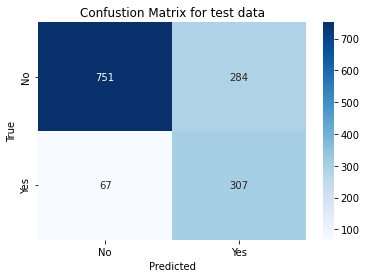

In [33]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

aoc = metrics.roc_auc_score(y_test, y_pred_proba)
f1 = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print("Model performance on Test data")
print("-" * 35)
print(f"aoc: {aoc:.2}")
print(f"f1: {f1:.2}")
print(f"precision: {precision:.2}")
print(f"recall: {recall:.2}")

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(
    metrics.confusion_matrix(y_test, y_pred),
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=["No", "Yes"],
    yticklabels=["No", "Yes"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confustion Matrix for test data")
plt.show()

In [34]:
model_perf = pd.DataFrame(
    columns=["Model", "test auc", "test f1", "test precision", "test recall"]
)

model_perf = model_perf.append(
    dict(zip(model_perf.columns, [model_name, aoc, f1, precision, recall])),
    ignore_index=True,
)
model_perf

,Model,test auc,test f1,test precision,test recall
0,XGBoost (all features),0.850218,0.636269,0.519459,0.820856


# Model inferencing using SHAP

In [14]:
import shap

In [36]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

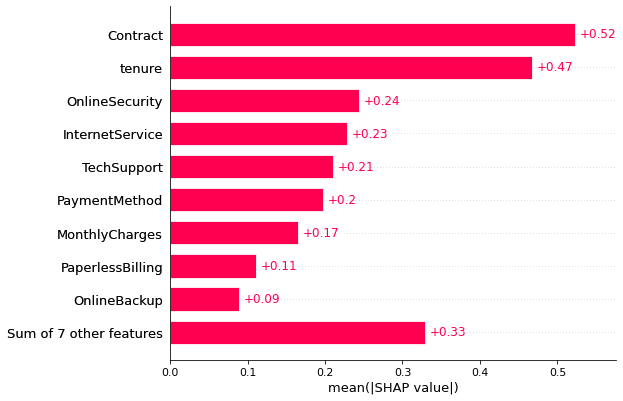

In [37]:
shap.plots.bar(shap_values)

In [38]:
# get top features with highest magnitude shap values
mean_shap = np.abs(shap_values.values).mean(0)

# getting those indices where mean shap values is greater than 0
imp_feat = np.argwhere(mean_shap > 0)

# getting those indices of mean_shap values descending
vals_indice = np.argsort(mean_shap)[::-1]  # descending

# the features with high magnitude
top_feat = x_train.columns[[i for i in vals_indice if i in imp_feat]]
x_train_new = x_train.loc[:, top_feat].copy()
x_test_new = x_test.loc[:, top_feat].copy()

print(f"No. of columns remove because of 0 mean Shapley Values: {len(imp_feat)}")

No. of columns remove because of 0 mean Shapley Values: 16


In [39]:
def objective(trial, data=x_train_new, target=y_train):
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
        ),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_categorical("max_depth", [i + 1 for i in range(9)]),
        "random_state": 420,
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "scale_pos_weight": weight,
    }
    model = xgb.XGBClassifier(**param)

    cv = model_selection.RepeatedStratifiedKFold(
        n_splits=3, n_repeats=2, random_state=420
    )

    scores = model_selection.cross_val_score(
        model, data, target, scoring="f1", cv=cv, n_jobs=-1
    )

    return np.mean(scores)

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2021-10-18 19:31:47,015] A new study created in memory with name: no-name-5218544d-7849-4a04-9804-722f3b6f55b9
[I 2021-10-18 19:31:48,115] Trial 0 finished with value: 0.6257141699821362 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 499, 'max_depth': 1, 'min_child_weight': 70}. Best is trial 0 with value: 0.6257141699821362.
[I 2021-10-18 19:31:49,554] Trial 1 finished with value: 0.6337095088539696 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 547, 'max_depth': 5, 'min_child_weight': 113}. Best is trial 1 with value: 0.6337095088539696.
[I 2021-10-18 19:31:50,201] Trial 2 finished with value: 0.6280940095287819 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 188, 'max_depth': 3, 'min_child_weight': 54}. Best is trial 1 with value: 0.6337095088539696.
[I 2021-10-18 19:31:54,171] Trial 3 finished with value: 0.6189592127116397

Number of finished trials: 50
Best trial: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 511, 'max_depth': 3, 'min_child_weight': 72}


In [41]:
model_name = "XGBoost (top features)"
params[model_name] = study.best_params
params[model_name]["scale_pos_weight"] = weight
params[model_name]["random_state"] = 420
model = xgb.XGBClassifier(**params[model_name])
cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

In [42]:
for score in ["roc_auc", "f1", "precision", "recall"]:
    scores = model_selection.cross_val_score(
        model, x_train_new, y_train, scoring=score, cv=cv, n_jobs=-1
    )
    print(f"Mean {score}: {np.mean(scores):.2f}")

Mean roc_auc: 0.85
Mean f1: 0.63
Mean precision: 0.53
Mean recall: 0.80


Model performance on Test data
-----------------------------------
aoc: 0.85
f1: 0.63
precision: 0.51
recall: 0.82


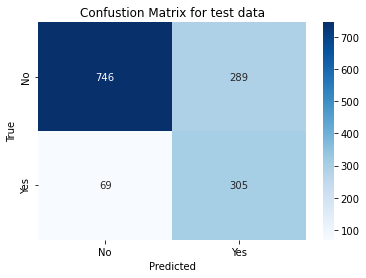

In [43]:
model.fit(x_train_new, y_test)
y_pred = model.predict(x_test_new)
y_pred_proba = model.predict_proba(x_test_new)[:, 1]

aoc = metrics.roc_auc_score(y_test, y_pred_proba)
f1 = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print("Model performance on Test data")
print("-" * 35)
print(f"aoc: {aoc:.2}")
print(f"f1: {f1:.2}")
print(f"precision: {precision:.2}")
print(f"recall: {recall:.2}")

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(
    metrics.confusion_matrix(y_test, y_pred),
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=["No", "Yes"],
    yticklabels=["No", "Yes"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confustion Matrix for test data")
plt.show()

In [44]:
model_perf = model_perf.append(
    dict(zip(model_perf.columns, [model_name, aoc, f1, precision, recall])),
    ignore_index=True,
)
model_perf.sort_values(by="test f1", ascending=False, inplace=True)
model_perf

,Model,test auc,test f1,test precision,test recall
0,XGBoost (all features),0.850218,0.636269,0.519459,0.820856
1,XGBoost (top features),0.851845,0.630165,0.513468,0.815508


In [15]:
# model = xgb.XGBClassifier(
#     **params[model_perf["Model"].values[0]] #first element has the highest test f1
# )
# if model_perf["Model"].values[0] == "XGBoost (top features)":
#     x_tr = x_train_new
#     x_te = x_test_new
# else:
#     x_tr = x_train
#     x_te = x_test
# model.fit(x_tr,y_train)

model = joblib.load(os.path.join(MAIN_FOLDER, "model/best_model.pkl"))
model.fit(x_train, y_train)
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

In [58]:
# save explainer for future use
# joblib.dump(explainer, os.path.join(MAIN_FOLDER,'model/shap_explainer.pkl'))
explainer = joblib.load(os.path.join(MAIN_FOLDER, "model/shap_explainer.pkl"))

['../model/shap_explainer.pkl']

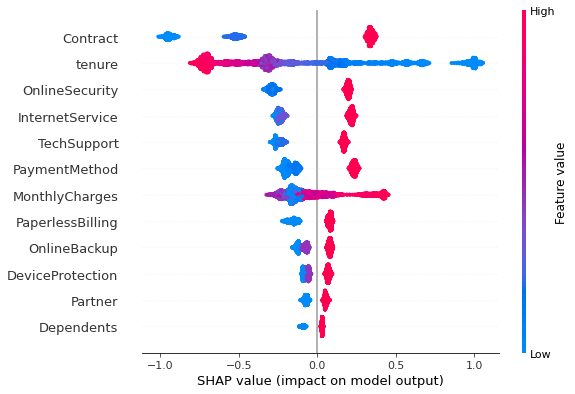

In [53]:
shap.summary_plot(shap_values, max_display=12)

In [54]:
# save the best model object to a file
# with open(os.path.join(MAIN_FOLDER,'model/best_model.pkl'),'wb') as f:
#     joblib.dump(model,f)

# Model inferencing using SHAP (SHapley Additive exPlanations)

Interesting inference observations from the above chart (Note: The feature importance are in descending order):
*   Here `Contract` is the most important feature for the model and `Dependents` is the least important feature out of the shown features.
*   Customer who were on `Month-to-Month` Contract are more likely to churn than those who were on `One Year` Contract and `Two Year` Contract.
*   Also as the value for `tenure` increases, the probability of churn for a specific customer decreases. Most of the customers who churned were recently joined.
*   People who did not opt for `OnlineSecurity` had a higher churn rate.
*   People who were on `Fiber optic` connection were more likely to churn than others. The company should investigate the quality of the fiber optic service they offer.
*   People who had high `MonthlyCharges` are more likely to churn.
*   Customers who did not opt for `TechSupport` service had a higher churn rate.
*   Customers who paid by `Electronic check` were more likely to churn than others (`Bank transfer (automatic)`, `Credit card (automatic)`,`Mailed check` )[`PaymentMethod` feature].
*   Customers who had signed for `Online Security` service were less likely to churn than those who did not.
*   People who had signed for `TechSupport` service were less likely to churn than those who did not.

In [55]:
resp_enc.master_dict

{'Partner': {'No': 0.33, 'Yes': 0.19, 'UNK': 0.5},
 'Dependents': {'No': 0.31, 'Yes': 0.15, 'UNK': 0.5},
 'MultipleLines': {'No': 0.25,
  'Yes': 0.28,
  'No phone service': 0.25,
  'UNK': 0.5},
 'InternetService': {'Fiber optic': 0.41, 'DSL': 0.19, 'No': 0.08, 'UNK': 0.5},
 'OnlineSecurity': {'No': 0.42,
  'No internet service': 0.08,
  'Yes': 0.14,
  'UNK': 0.5},
 'OnlineBackup': {'Yes': 0.22,
  'No': 0.39,
  'No internet service': 0.08,
  'UNK': 0.5},
 'DeviceProtection': {'No': 0.39,
  'Yes': 0.22,
  'No internet service': 0.08,
  'UNK': 0.5},
 'TechSupport': {'No': 0.42,
  'No internet service': 0.08,
  'Yes': 0.15,
  'UNK': 0.5},
 'StreamingTV': {'No': 0.34,
  'Yes': 0.3,
  'No internet service': 0.08,
  'UNK': 0.5},
 'StreamingMovies': {'No': 0.34,
  'No internet service': 0.08,
  'Yes': 0.29,
  'UNK': 0.5},
 'Contract': {'Month-to-month': 0.43,
  'One year': 0.11,
  'Two year': 0.03,
  'UNK': 0.5},
 'PaperlessBilling': {'Yes': 0.34, 'No': 0.16, 'UNK': 0.5},
 'PaymentMethod': {'E

# Next Steps

* Produce python scripts to ensure future training can be done smoothly and can be reproduced.
* Create a web application to visualize the results and also predict the results.